<a href="https://colab.research.google.com/github/ElenaBianchini/ColoringGrayscaleImages/blob/main/ProgettoLabIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto di Laboratorio di Intelligenza Artificiale e Grafica Interattiva**

# Import

In [1]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import color
from PIL import Image

# Impostazione dei parametri

In [5]:
num_epochs = 5
batch_size = 32
learning_rate = 1e-3
use_gpu = torch.cuda.is_available()

In [6]:
if use_gpu:
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [7]:
device

device(type='cpu')

# Paths

In [8]:
root_path = "/content/drive/MyDrive/COCO"

In [9]:
train_folder = root_path+"/train2014/"
val_folder = root_path+"/val2014/"
test_folder = root_path+"/test2014/"

# Dataset

In [10]:
def loadImagesName(dir_path, num):
    images_list = []
    count = 1
    for image_name in os.listdir(dir_path):
      if (count>num):
        break
      filename = os.path.join(dir_path, image_name)
      images_list.append(filename)
      print("\rImage num: {}".format(count), end='')
      count = count+1
    
    return images_list


In [19]:
train_list = loadImagesName(train_folder, 5000)

Image num: 5000

In [16]:
val_list = loadImagesName(val_folder, 2500)

Image num: 2500

In [15]:
test_list = loadImagesName(test_folder, 1875)

Image num: 1875

In [11]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images_list):
    self.images_list = images_list
    self.img_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
    ])

  def __len__(self):
    return len(self.images_list)
  
  def __getitem__(self, idx):
    img = Image.open(self.images_list[idx]).convert('RGB')
    img = self.img_transform(img)
    img = np.asarray(img)
    img_lab = color.rgb2lab(img) # restituisce un numpy
    img_lab = (img_lab + 128) / 255    # perché i valori dei canali ab del formato Lab vanno da -128 a 127 e li vogliamo tra [0,1]
    img_ab = img_lab[:, :, 1:3] # forma: WxHxC = [224, 224, 2]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_gray = color.rgb2gray(img)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    img = torch.from_numpy(img.transpose((2, 0, 1))).float()
    return img, img_ab, img_gray


In [20]:
train_dataset = ImageDataset(train_list)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
val_dataset = ImageDataset(val_list)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [22]:
test_dataset = ImageDataset(test_list)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)


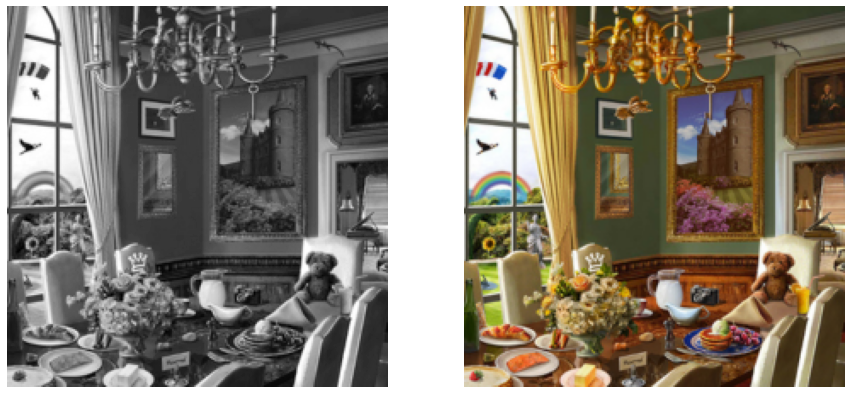

In [23]:
for i, (img, img_ab, img_gray) in enumerate(test_dataloader):
  gray = img_gray[0].squeeze().numpy()
  ab = img_ab[0].numpy().transpose(1,2,0)
  real = img[0].numpy().transpose(1,2,0).astype(int)
  f, ax = plt.subplots(1,2)
  f.set_size_inches(15, 15)
  ax[0].imshow(gray, cmap='gray')
  #ax[1].imshow(ab)
  ax[1].imshow(real)
  ax[0].axis('off'),ax[1].axis('off')
  plt.show()
  break

# Regressione

## Modello

In [24]:
class ColorizationRNet(nn.Module):
  def __init__(self, input_size = 128):
    super(ColorizationRNet, self).__init__()

    # Importo ResNet che userò per estrarre le features dalle immagini
    resnet = torchvision.models.resnet18()
    # Cambio il primo livello di convoluzione di ResNet per accetta input con un solo canale
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Estraggo le feature dalle immagini
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    # Livelli di deconvoluzione:
    self.deconv = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    x = self.midlevel_resnet(x)
    output = self.deconv(x)
    return output

In [25]:
reg_net = ColorizationRNet()
reg_net = reg_net.to(device)

## Funzione di costo e di ottimizzazione

In [26]:
optimizer = torch.optim.Adam(params=reg_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion = criterion.to(device)

## Train

In [27]:
def train(epoch, loss_avg):
  # Set model to training model
  reg_net.train()

  print('\nStarting training epoch {}\n'.format(epoch))

  loss_avg.append(0)

  for batch_idx, (img, img_ab, img_gray) in enumerate(train_dataloader):
    img = img.to(device)
    img_ab = img_ab.to(device)
    img_gray = img_gray.to(device)

    # Predizione dell'immagine ab da grayscale
    predicted = reg_net(img_gray)
  
    # Calcolo l'errore L2 tra i colori ottenuti e quelli veri:
    loss = criterion(predicted, img_ab)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Aggiorno i pesi:
    optimizer.step()

    loss_avg[-1]+=loss.item()

    if batch_idx % 20 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.6f}'.format(
            epoch, batch_idx*len(img), len(train_dataloader.dataset), 100. * batch_idx / len(train_dataloader), loss.item()))

  loss_avg[-1]/= batch_size
  print('\nFinished training epoch {}\n'.format(epoch))


## Validation

In [28]:
def validation(epoch, val_loss_avg):
  # Set model to validation model
  reg_net.eval()

  val_loss_avg.append(0)

  for batch_idx, (img, img_ab, img_gray)in enumerate(val_dataloader):
    img = img.to(device)
    img_ab = img_ab.to(device)
    img_gray = img_gray.to(device)

    # Predizione dell'immagine ab da grayscale
    predicted = reg_net(img_gray)

    # Calcolo l'errore L2 tra i colori ottenuti e quelli veri:
    loss = criterion(predicted, img_ab)
    val_loss_avg[-1]+=loss.item()

    if batch_idx % 50 == 0:
        print('Validation Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.6f}'.format(
            epoch, batch_idx*len(img), len(val_dataloader.dataset), 100. * batch_idx / len(val_dataloader), loss.item()))

    # Salvo la prima foto di ogni epoca
    if batch_idx==0: 
      plt.clf() #clear matplotlib
      input_gray = img_gray[0].cpu().squeeze().numpy()
      output_color = torch.cat((img_gray[0].cpu(), predicted[0].detach().cpu()), 0).numpy()
      output_color = output_color.transpose((1,2,0))
      output_color[:, :, 0:1] = output_color[:, :, 0:1] * 100
      output_color[:, :, 1:3] = output_color[:, :, 1:3] * 255 - 128   
      output_color = color.lab2rgb(output_color.astype(np.float64))
      real_color = img[0].cpu().numpy().transpose((1,2,0)).astype(np.uint8)
      plt.imsave(arr=input_gray, fname = '/content/drive/MyDrive/ProgettoLab/immagini/{}_grayscale.jpg'.format(epoch),  cmap='gray')
      plt.imsave(arr=output_color, fname = '/content/drive/MyDrive/ProgettoLab/immagini/{}_recolored.jpg'.format(epoch))
      plt.imsave(arr=real_color, fname = '/content/drive/MyDrive/ProgettoLab/immagini/{}_real.jpg'.format(epoch))


  val_loss_avg[-1]/= batch_size
  print('\nValidation set: Average loss: {:.4f}\n'.format(val_loss_avg[-1]))
  return val_loss_avg[-1]


## Allenamento

In [ ]:
best_losses = 1.0
train_loss_avg = []
val_loss_avg = []

for epoch in range(1, num_epochs+1):
  train(epoch, train_loss_avg)
  losses = validation(epoch, val_loss_avg)

  if losses < best_losses:
    best_losses = losses
    torch.save(reg_net.state_dict(), '/content/drive/MyDrive/ProgettoLab/checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))



Starting training epoch 1

Train Epoch: 1 [0/5000 (0%)]  Loss: 0.806074
Train Epoch: 1 [384/5000 (8%)]  Loss: 0.014501
Train Epoch: 1 [768/5000 (15%)]  Loss: 0.008515
Train Epoch: 1 [1152/5000 (23%)]  Loss: 0.005361
Train Epoch: 1 [1536/5000 (31%)]  Loss: 0.008549
Train Epoch: 1 [1920/5000 (38%)]  Loss: 0.007133
Train Epoch: 1 [2304/5000 (46%)]  Loss: 0.008466
Train Epoch: 1 [2688/5000 (54%)]  Loss: 0.005647
Train Epoch: 1 [3072/5000 (61%)]  Loss: 0.004737
Train Epoch: 1 [3456/5000 (69%)]  Loss: 0.004152


## Grafico della curva di apprendimento

In [ ]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1),train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

NameError: ignored

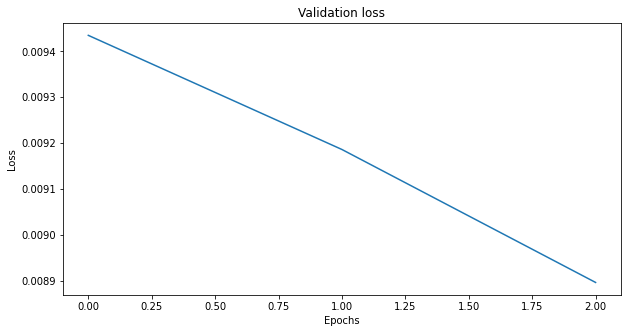

In [ ]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1), val_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.show()

## Risultato su un'immagine del Test Set

In [ ]:
path = '/content/drive/MyDrive/ProgettoLab/immagini/'

gray = Image.open(path+'5_grayscale.jpg')
recolored = Image.open(path+'5_recolored.jpg')
real = Image.open(path+'5_real.jpg')

f, ax = plt.subplots(1,3)
f.set_size_inches(15, 15)

ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Grayscale')

ax[1].imshow(recolored)
ax[1].set_title('Recolored')

ax[2].imshow(real)
ax[2].set_title('Real')

ax[0].axis('off'),ax[1].axis('off'), ax[2].axis('off')

plt.show()

# Classificazione 

## Modello

In [ ]:
class ColorizationCNet(nn.Module):
  def __init__(self):
    super(ColorizationCNet, self).__init__()

    self.network = nn.Sequential(
        nn.Conv2d(1,64,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64,128,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128,256,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(256,512,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.ConvTransposed2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

        nn.Conv2d(256, 313, kenel_size=1, stride=1, padding=0),
        nn.Softmax(dim=1),
        nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1),
        nn.Upsample(scale_factor=4)
    )


  def forward(self, x):
    output = self.network(x)
    return output

In [ ]:
clas_net = ColorizationCNet()

## Funzione di costo e di ottimizzazione

## Funzione per ottenere le label

In [ ]:
def get_labels(batch_ab):
  labels = []
  for img in batch_ab:
    label = np.zeros((224*224,313))
    img = np.reshape(img, (-1,2))
    distances, indices = knn.kneighbors(img, 5)
    weights = np.exp(-distances ** 2 / (2 * SIGMA ** 2))
    weights = weights / np.sum(weights, axis=1)[:, np.newaxis]
    label[self.pixel_idx, indices] = weights
    label = np.reshape(label, (IMAGE_HEIGHT, IMAGE_WIDTH, 313))
    labels.append(label)
  return labels

## Train

## Grafico della curva di apprendimento

## Valutazione sul Test Set

## Risultato su un'immagine del Test Set